In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import os
import cv2
import random

RAW_DIR = "../data/raw"
OUTPUT_DIR = "../data/processed/"
IMAGE_SIZE = (224, 224)  # For EfficientNetB0

def extract_class_id(filename):
    """Extract class like '001_1' from '001_1_1.tif'"""
    return "_".join(filename.split("_")[:2])

def preprocess_image(image_path):
    """Read grayscale, enhance contrast, denoise, resize, convert to RGB"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # 1. CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img)

    # 2. Bilateral Filter
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # 3. Resize
    resized = cv2.resize(denoised, IMAGE_SIZE, interpolation=cv2.INTER_LANCZOS4)

    # 4. Convert to 3-channel RGB
    rgb = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

    return Image.fromarray(rgb)


def prepare_dataset():
    all_files = [f for f in os.listdir(RAW_DIR) if f.endswith(".tif")]
    class_map = {}

    for file in all_files:
        class_id = extract_class_id(file)
        class_map.setdefault(class_id, []).append(file)

    for class_id, files in tqdm(class_map.items(), desc="Processing classes"):
        # Sort files by index (ZZZ)
        files.sort(key=lambda f: int(f.split("_")[2].split(".")[0]))

        train_files = files[:6]  # first 6 for train
        test_files = files[6:]   # last 2 for test

        for split, split_files in [("train", train_files), ("test", test_files)]:
            out_dir = os.path.join(OUTPUT_DIR, split, class_id)
            os.makedirs(out_dir, exist_ok=True)

            for file in split_files:
                img_path = os.path.join(RAW_DIR, file)
                processed_img = preprocess_image(img_path)
                processed_img.save(os.path.join(out_dir, file.replace(".tif", ".png")))

def add_custom_noise(img_array):
    noise = np.random.normal(loc=0, scale=10, size=img_array.shape)
    noisy_img = img_array + noise
    return np.clip(noisy_img, 0, 255)

def add_motion_blur(img_array, degree=5, angle=0):
    image = img_array.copy()
    k = np.zeros((degree, degree))
    k[int((degree - 1) / 2), :] = np.ones(degree)
    M = cv2.getRotationMatrix2D((degree / 2 - 0.5, degree / 2 - 0.5), angle, 1)
    k = cv2.warpAffine(k, M, (degree, degree))
    k = k / np.sum(k)
    blurred = cv2.filter2D(image, -1, k)
    return blurred

def damage_all_test_images(test_dir):
    print("\nDamaging ALL test images...")
    total_images = 0

    for class_id in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_id)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

        for fname in tqdm(images, desc=f"Damaging {class_id}"):
            img_path = os.path.join(class_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is not None:
                damaged = apply_combined_damage(img)
                cv2.imwrite(img_path, damaged)
                total_images += 1

    print(f"\nTotal test images damaged: {total_images}")


def augment_and_save_images_in_place(input_dir, augmentations_per_image=5):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=5,
        zoom_range=0.05,
        brightness_range=(0.9, 1.1),
        fill_mode='nearest'
    )

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for fname in tqdm(os.listdir(class_path), desc=f"Augmenting {class_name}"):
            if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            fpath = os.path.join(class_path, fname)
            img = load_img(fpath, color_mode='rgb')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            prefix = os.path.splitext(fname)[0]
            i = 0
            for batch in datagen.flow(x, batch_size=1):
                aug_img_array = batch[0]

                if np.random.rand() < 0.5:
                    aug_img_array = add_custom_noise(aug_img_array)

                if np.random.rand() < 0.3:
                    degree = np.random.randint(3, 7)
                    angle = np.random.uniform(-20, 20)
                    aug_img_array = add_motion_blur(aug_img_array, degree=degree, angle=angle)

                aug_img_array = np.clip(aug_img_array, 0, 255).astype('uint8')

                if aug_img_array.ndim == 2:
                    aug_img_array = np.expand_dims(aug_img_array, axis=-1)

                aug_img = array_to_img(aug_img_array)
                aug_img.save(os.path.join(class_path, f"{prefix}_aug{i+1}.png"))
                i += 1
                if i >= augmentations_per_image:
                    break

def apply_light_block_damage(image, block_size=40, num_blocks=4):
    damaged = np.copy(image)
    h, w, _ = damaged.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = gray < 250

    ys, xs = np.where(mask)

    if len(xs) == 0:
        return damaged

    for _ in range(num_blocks):
        idx = random.randint(0, len(xs) - 1)
        x_center, y_center = xs[idx], ys[idx]
        x1 = max(0, x_center - block_size // 2)
        y1 = max(0, y_center - block_size // 2)
        x2 = min(w, x1 + block_size)
        y2 = min(h, y1 + block_size)
        damaged[y1:y2, x1:x2] = 255
    return damaged

def apply_blur_damage(image, block_size=30, num_blocks=4):
    damaged = np.copy(image)
    height, width = image.shape[:2]

    for _ in range(num_blocks):
        x = random.randint(0, width - block_size)
        y = random.randint(0, height - block_size)
        roi = damaged[y:y+block_size, x:x+block_size]
        blurred = cv2.GaussianBlur(roi, (11, 11), 0)
        damaged[y:y+block_size, x:x+block_size] = blurred
    return damaged

def apply_elliptical_noise(image, num_ellipses=3):
    damaged = np.copy(image)
    height, width = image.shape[:2]

    for _ in range(num_ellipses):
        center = (
            random.randint(0, width),
            random.randint(0, height)
        )
        axes = (
            random.randint(20, 60), 
            random.randint(10, 30)   
        )
        angle = random.randint(0, 180)
        startAngle = 0
        endAngle = 360
        color = (255, 255, 255)
        thickness = -1 

        cv2.ellipse(damaged, center, axes, angle, startAngle, endAngle, color, thickness)
    return damaged

def apply_combined_damage(image):
    image = apply_light_block_damage(image)
    image = apply_blur_damage(image)
    image = apply_elliptical_noise(image)
    return image


def damage_percent_of_training_images(train_dir):
    total_clean = 0
    total_damaged = 0

    print("\n Applying combined damage to 20% of training images per class...")

    for class_id in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_id)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
        num_images = len(images)
        num_to_damage = int(num_images * 0.2)

        selected = random.sample(images, num_to_damage)

        for fname in selected:
            img_path = os.path.join(class_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is not None:
                damaged = apply_combined_damage(img)
                cv2.imwrite(img_path, damaged)

        total_clean += (num_images - num_to_damage)
        total_damaged += num_to_damage
        print(f"Class {class_id}: {num_images - num_to_damage} clean + {num_to_damage} damaged")

    print(f"\nFinal training set: {total_clean + total_damaged} total — {total_clean} clean + {total_damaged} damaged")

# Run this cell step by step

print("Preprocessing and splitting dataset...")
prepare_dataset()

print("Starting augmentation on training data...")
augment_and_save_images_in_place(os.path.join(OUTPUT_DIR, "train"), augmentations_per_image=5)

damage_percent_of_training_images("../data/processed/train/")

damage_all_test_images(os.path.join(OUTPUT_DIR, "test"))

print("All done!")


Preprocessing and splitting dataset...


Processing classes: 100%|██████████| 257/257 [00:22<00:00, 11.40it/s]


Starting augmentation on training data...


Augmenting 031_257: 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]



 Applying combined damage to 20% of training images per class...
Class 001_1: 29 clean + 7 damaged
Class 001_2: 29 clean + 7 damaged
Class 001_3: 29 clean + 7 damaged
Class 001_4: 29 clean + 7 damaged
Class 001_5: 29 clean + 7 damaged
Class 001_6: 29 clean + 7 damaged
Class 002_10: 29 clean + 7 damaged
Class 002_11: 29 clean + 7 damaged
Class 002_12: 29 clean + 7 damaged
Class 002_7: 29 clean + 7 damaged
Class 002_8: 29 clean + 7 damaged
Class 002_9: 29 clean + 7 damaged
Class 003_13: 29 clean + 7 damaged
Class 003_14: 29 clean + 7 damaged
Class 003_15: 29 clean + 7 damaged
Class 003_16: 29 clean + 7 damaged
Class 003_17: 29 clean + 7 damaged
Class 003_18: 29 clean + 7 damaged
Class 004_19: 29 clean + 7 damaged
Class 004_20: 29 clean + 7 damaged
Class 004_21: 29 clean + 7 damaged
Class 004_22: 29 clean + 7 damaged
Class 004_23: 29 clean + 7 damaged
Class 004_24: 29 clean + 7 damaged
Class 005_25: 29 clean + 7 damaged
Class 005_26: 29 clean + 7 damaged
Class 005_27: 29 clean + 7 damage

Damaging 031_257: 100%|██████████| 2/2 [00:00<00:00, 155.13it/s]


✅ Total test images damaged: 514
All done!


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [29]:
train_dir = "../data/processed/train"
test_dir = "../data/processed/test"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = len(os.listdir(train_dir))  # number of folders = number of classes
EPOCHS = 100


In [30]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # assuming you're using sparse categorical crossentropy
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)


Found 9252 images belonging to 257 classes.
Found 514 images belonging to 257 classes.


In [31]:
from tensorflow.keras.regularizers import l2
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    factor=0.5, 
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_fingerprint_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Train model with callbacks
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
579/579 [==============================] - 112s 178ms/step - loss: 7.7017 - accuracy: 0.0050 - val_loss: 7.6662 - val_accuracy: 0.0117 - lr: 1.0000e-05
Epoch 2/100
579/579 [==============================] - 77s 132ms/step - loss: 7.6166 - accuracy: 0.0107 - val_loss: 7.6080 - val_accuracy: 0.0175 - lr: 1.0000e-05
Epoch 3/100
579/579 [==============================] - 78s 134ms/step - loss: 7.5167 - accuracy: 0.0203 - val_loss: 7.5435 - val_accuracy: 0.0253 - lr: 1.0000e-05
Epoch 4/100
579/579 [==============================] - 85s 147ms/step - loss: 7.3787 - accuracy: 0.0367 - val_loss: 7.4655 - val_accuracy: 0.0311 - lr: 1.0000e-05
Epoch 5/100
579/579 [==============================] - 115s 199ms/step - loss: 7.1985 - accuracy: 0.0543 - val_loss: 7.3656 - val_accuracy: 0.0389 - lr: 1.0000e-05
Epoch 6/100
579/579 [==============================] - 115s 198ms/step - loss: 6.9856 - accuracy: 0.0674 - val_loss: 7.2363 - val_accuracy: 0.0545 - lr: 1.0000e-05
Epoch 7/100
579/579

In [32]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Loss: {loss:.4f}")
print(f" Test Accuracy: {accuracy:.4f}")

33/33 [==============================] - 1s 29ms/step - loss: 2.8440 - accuracy: 0.6051

 Test Loss: 2.8440
 Test Accuracy: 0.6051


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
X_test = []
y_test = []

steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

for i in range(steps):
    x, y = next(test_generator)
    X_test.append(x)
    y_test.append(y)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_probs = model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

33/33 [==============================] - 3s 29ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     0.5000    1.0000    0.6667         2
         1.0     1.0000    0.5000    0.6667         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    0.5000    0.6667         2
         4.0     1.0000    0.5000    0.6667         2
         5.0     0.2500    0.5000    0.3333         2
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.5000    0.5000    0.5000         2
         8.0     0.0000    0.0000    0.0000         2
         9.0     1.0000    1.0000    1.0000         2
        10.0     0.2000    0.5000    0.2857         2
        11.0     0.2000    0.5000    0.2857         2
        12.0     1.0000    1.0000    1.0000         2
        13.0     1.0000    0.5000    0.6667         2
        14.0     0.6667    1.0000    0.8000         2
        15.0     1.0000    1.0000    1.0000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 26ms/step


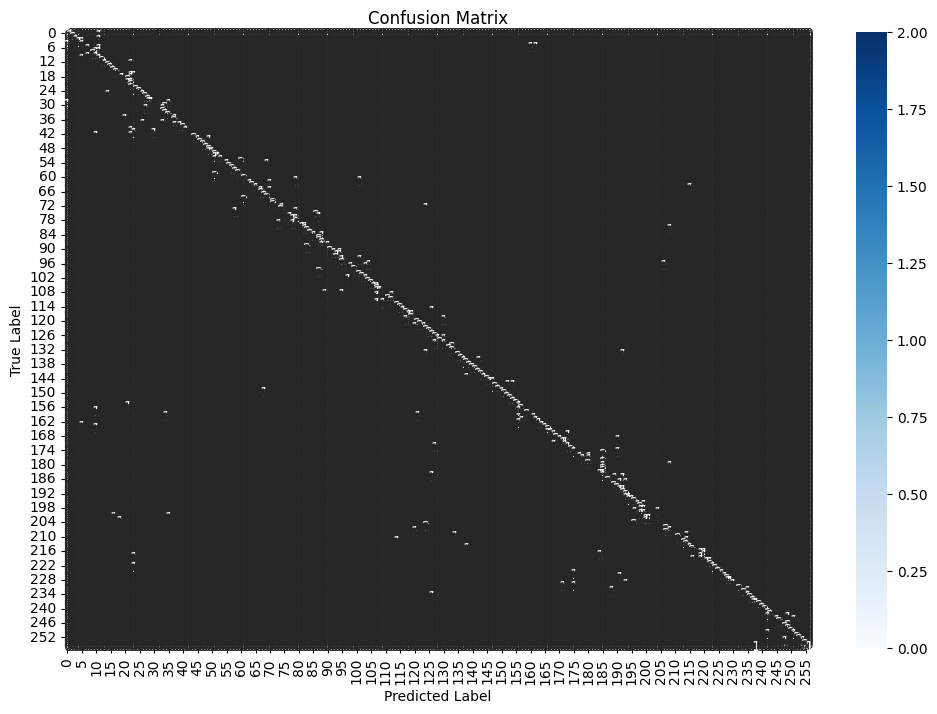

In [35]:
# run abis code block bawah
import seaborn as sns
import matplotlib.pyplot as plt
y_true = []
y_pred = []

test_generator.reset()
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_generator)

    if y_batch.ndim > 1:
        y_true.extend(np.argmax(y_batch, axis=1))
    else:
        y_true.extend(y_batch)
    
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

report = classification_report(y_test, y_pred, output_dict=True)

precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

print(f"\nMacro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")



Classification Report:
              precision    recall  f1-score   support

         0.0     0.5000    1.0000    0.6667         2
         1.0     1.0000    0.5000    0.6667         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    0.5000    0.6667         2
         4.0     1.0000    0.5000    0.6667         2
         5.0     0.2500    0.5000    0.3333         2
         6.0     0.0000    0.0000    0.0000         2
         7.0     0.5000    0.5000    0.5000         2
         8.0     0.0000    0.0000    0.0000         2
         9.0     1.0000    1.0000    1.0000         2
        10.0     0.2000    0.5000    0.2857         2
        11.0     0.2000    0.5000    0.2857         2
        12.0     1.0000    1.0000    1.0000         2
        13.0     1.0000    0.5000    0.6667         2
        14.0     0.6667    1.0000    0.8000         2
        15.0     1.0000    1.0000    1.0000         2
        16.0     0.6667    1.0000    0.8000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENO